# FiftyOne: Image Classification

This notebook follows the tutorial [Evaluating a Classifier with FiftyOne](https://docs.voxel51.com/tutorials/evaluate_classifications.html).
The following tasks are carried out:

- A FiftyOne dataset is created from a image binary classification dataset.
- A Fast.ai CNN is trained with the dataset.
- The model is used to predict the image classes.
- Sample predictions are uploaded to FiftyOne.
- The UI is used to filter samples, i.e., FN & FP samples according to priorization scalars like `hardness`.
- Exports are done: wrong samples (FP, FN) and entire dataset as a JSON.

In the tutorial, the [Malaria Dataset @ Kaggle](https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria) is used, which contains 13.7k x 2 images (size around 150**2 px) of two classes: 

- cell `Infected` with malaria
- cell `Uninfected` with malaria

Table of contents:

1. Setup: Install Libraries & Download Dataset
2. Load dataset into FiftyOne and Visualize It
3. Train a Model with Fast.ai
4. Evaluate the Model with Fast.ai
   - Add Predictions to FiftyOne
   - Running the Evaluation with FiftyOne after Predictions Have Been Added
   - Hardness and Mistakenness
   - Launch the App/UI and Visualize Metrics or Selected Samples
5. Export: Dataset, Selected Samples
   - Export incorrect samples for further analysis
   - Export Dataset

## 1. Setup: Install Libraries & Download Dataset

In [ ]:
!pip install fiftyone

In [ ]:
#!pip install torch torchvision

# OPTIONAL: Pytorch on Windows + CUDA 11.7
# Update your NVIDIA drivers: https://www.nvidia.com/Download/index.aspx
# I have version 12.1, but it works with older versions, e.g. 11.7
# Check your CUDA version with: nvidia-smi.exe
# In case of any runtime errors, check vrsion compatibility tables:
# https://github.com/pytorch/vision#installation
!pip install -U torch==1.13+cu117 torchvision==0.14+cu117 torchaudio torchtext==0.14 --index-url https://download.pytorch.org/whl/cu117

^C


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Msagardi\\AppData\\Local\\anaconda3\\envs\\label\\Lib\\site-packages\\~orch\\lib\\asmjit.dll'
Consider using the `--user` option or check the permissions.



Looking in indexes: https://download.pytorch.org/whl/cu117
     ---------------------------------------- 0.0/2.3 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.3 GB 30.7 MB/s eta 0:01:14
     ---------------------------------------- 0.0/2.3 GB 37.7 MB/s eta 0:01:00
     ---------------------------------------- 0.0/2.3 GB 69.0 MB/s eta 0:00:33
     ---------------------------------------- 0.0/2.3 GB 73.1 MB/s eta 0:00:31
     ---------------------------------------- 0.0/2.3 GB 72.6 MB/s eta 0:00:31
     ---------------------------------------- 0.0/2.3 GB 65.6 MB/s eta 0:00:35
     ---------------------------------------- 0.0/2.3 GB 65.6 MB/s eta 0:00:35
     ---------------------------------------- 0.0/2.3 GB 72.6 MB/s eta 0:00:31
     ---------------------------------------- 0.0/2.3 GB 72.6 MB/s eta 0:00:31
      --------------------------------------- 0.0/2.3 GB 65.6 MB/s eta 0:00:34
      --------------------------------------- 0.0/2.3 GB 81.8 MB/s eta 0:00:28
 

In [3]:
!pip install --upgrade kaggle

     ---------------------------------------- 0.0/83.6 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/83.6 kB ? eta -:--:--
     ------------- ------------------------ 30.7/83.6 kB 330.3 kB/s eta 0:00:01
     -------------------------------------- 83.6/83.6 kB 586.8 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached python_slugify-8.0.1-py2.py3-none-any.whl (9.7 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110696 sha256=ef8be7c0dc41dda257cbd4173b4e01971dff6d3f4d2d0b9a5a15378cff0556ad
  Stored in directory: c:\users\msagardi\appdata\local\pip\cache\wheels\d2\ed\a5\da3a0cfb13373d1ace41cafa4f2467d858c55c52473ba72799
Successfully built kaggle


If we install kaggle properly and download the `kaggle.json` to `~/.kaggle`, we don't need the following environment variables:

```bash
%%bash

# You can create an account for free and get an API token as follows:
# kaggle.com > account > API > Create new API token
export KAGGLE_USERNAME=XXXXXXXXXXXXXXXX
export KAGGLE_KEY=XXXXXXXXXXXXXXXX
```

In [6]:
%%sh

# Download the dataset
kaggle datasets download -d iarunava/cell-images-for-detecting-malaria -p ../datasets/

100%|██████████| 675M/675M [00:20<00:00, 34.5MB/s] 


In [7]:
%%sh

# Uncompress
unzip ../datasets/cell-images-for-detecting-malaria.zip -d ../datasets/

Archive:  ../datasets/cell-images-for-detecting-malaria.zip
  inflating: ../datasets/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png  
  inflating: ../datasets/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png  
  inflating: ../datasets/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_164.png  
  inflating: ../datasets/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_165.png  
  inflating: ../datasets/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_166.png  
  inflating: ../datasets/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_167.png  
  inflating: ../datasets/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_168.png  
  inflating: ../datasets/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_169.png  
  inflating: ../datasets/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_170.png  
  inflating: ../datasets/cell_images/Parasitized/C100P61ThinF_IMG_2

In [1]:
%%sh

# Housekeeping
rm -rf ../datasets/cell_images/cell_images
rm ../datasets/cell_images/Parasitized/Thumbs.db
rm ../datasets/cell_images/Uninfected/Thumbs.db
rm ../datasets/cell-images-for-detecting-malaria.zip

In [3]:
%%sh

# Count
ls -lah ../datasets/cell_images/Uninfected | head
ls -lah ../datasets/cell_images/Parasitized | head

printf "\nClass counts\n"
ls -lah ../datasets/cell_images/Uninfected | wc -l
ls -lah ../datasets/cell_images/Parasitized | wc -l

total 181M
drwxr-xr-x 1 msagardi Domain Users    0 Nov  2 16:50 .
drwxr-xr-x 1 msagardi Domain Users    0 Nov  2 16:50 ..
-rw-r--r-- 1 msagardi Domain Users  11K Oct 14  2019 C100P61ThinF_IMG_20150918_144104_cell_128.png
-rw-r--r-- 1 msagardi Domain Users  12K Oct 14  2019 C100P61ThinF_IMG_20150918_144104_cell_131.png
-rw-r--r-- 1 msagardi Domain Users 9.8K Oct 14  2019 C100P61ThinF_IMG_20150918_144104_cell_144.png
-rw-r--r-- 1 msagardi Domain Users 5.9K Oct 14  2019 C100P61ThinF_IMG_20150918_144104_cell_21.png
-rw-r--r-- 1 msagardi Domain Users 9.5K Oct 14  2019 C100P61ThinF_IMG_20150918_144104_cell_25.png
-rw-r--r-- 1 msagardi Domain Users 7.6K Oct 14  2019 C100P61ThinF_IMG_20150918_144104_cell_34.png
-rw-r--r-- 1 msagardi Domain Users  11K Oct 14  2019 C100P61ThinF_IMG_20150918_144104_cell_48.png
total 205M
drwxr-xr-x 1 msagardi Domain Users    0 Nov  2 16:50 .
drwxr-xr-x 1 msagardi Domain Users    0 Nov  2 16:50 ..
-rw-r--r-- 1 msagardi Domain Users  14K Oct 14  2019 C100P61ThinF_I

## 2. Load dataset into FiftyOne and Visualize It

In [15]:
import os
import fiftyone as fo

DATASET_DIR = os.path.join(os.getcwd(),"..","datasets","cell_images")
#print(DATASET_DIR)

In [7]:
# Create FiftyOne dataset
# Images remain in local folder
# but a database is generated/updated in ~/.fiftyone
# Later, we can reference the dataset with its name
# and the content of the database is loaded
# Other ways of importing datasets to FiftyOne:
# https://docs.voxel51.com/user_guide/dataset_creation/index.html
dataset = fo.Dataset.from_dir(
    DATASET_DIR,
    fo.types.ImageClassificationDirectoryTree,
    name="malaria-cell-images",
)
dataset.persistent = True

print(dataset)

 100% |█████████████| 27558/27558 [11.7s elapsed, 0s remaining, 2.3K samples/s]       
Name:        malaria-cell-images
Media type:  image
Num samples: 27558
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


In [16]:
# Load existing dataset
dataset = fo.load_dataset("malaria-cell-images")
print(dataset)

Name:        malaria-cell-images
Media type:  image
Num samples: 27558
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    uniqueness:   fiftyone.core.fields.FloatField
    predictions:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    eval:         fiftyone.core.fields.StringField


In [9]:
# Compute visual uniqueness
# https://docs.voxel51.com/user_guide/brain.html#image-uniqueness
# A model is downloaded for us and a scalar [0, 1]
# related to the uniqueness of each image is computed
# following different computations: embeddings, neighbors, etc.
# Unique samples are vital in creating training batches
# that help your model learn as efficiently and effectively as possible.
import fiftyone.brain as fob

fob.compute_uniqueness(dataset)

 100% |████|  100.6Mb/100.6Mb [349.8ms elapsed, 0s remaining, 287.5Mb/s]      
Computing embeddings...
 100% |█████████████| 27558/27558 [3.8m elapsed, 0s remaining, 119.4 samples/s]      
Computing uniqueness...
Computing neighbors for 27558 embeddings; this may take awhile...
Uniqueness computation complete


### Launch the App

We can launch the FiftyOne UI app in several ways; the two most common ways:

1. With code in our environment:

    ```python
    session = fo.launch_app(dataset, desktop=True) # Browser: http://localhost:5151
    session = fo.launch_app(dataset, desktop=False) # Embedded in Jupyter
    ```

2. In the CLI:

    ```bash
    # fiftyone app launch <dataset_name>
    (label) fiftyone app launch "malaria-cell-images"
    # Browser: http://localhost:5151
    ```

Launching the UI in the code has the advantage of obtaining the `session` object, with which can do additional things. However, if we use this approach:

- We should use Jupyter Lab notebooks, not VSCode; otherwise, we might have issues.
- We can click on "Create new View for Cell Output" and put the view side-by-side with our notebook code.

Basic usage of the UI:

- Left frame: select tags / labels / primitives (features added in code)
- Main frame: we can visualize several **panels**
  - Samples: we can click on each of them and a detailed view is opened
  - Histograms: we can select which vaiables to plot: labels, scalar values, etc.
  - Embeddings: we can plot scatterplots that represent the dataset
- We can add stages or filters, e.g.:
  - `Limit(int)` takes the number of samples we specify
  - `SortBy`
  - ...

![Malaria Dataset: UI](../assets/malaria_ui.png)

## 3. Train a Model with Fast.ai

In [10]:
!pip install --upgrade fastai

  Obtaining dependency information for fastai from https://files.pythonhosted.org/packages/b4/44/25472496c58a9c4aa43465ae8daffb4452ebbe61b43342fe0f8a53ed836b/fastai-2.7.13-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/67.6 kB ? eta -:--:--
     ------------------ --------------------- 30.7/67.6 kB ? eta -:--:--
     ---------------------------------------- 67.6/67.6 kB 1.9 MB/s eta 0:00:00
  Obtaining dependency information for spacy<4 from https://files.pythonhosted.org/packages/f7/a8/ce2bf530416327386d10f9ed577a600a5499987cb3368215b46c7b2f7221/spacy-3.7.2-cp39-cp39-win_amd64.whl.metadata
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl (29 kB)
  Obtaining dependency information for spacy-loggers<2.0.0,>=1.0.0 from https://files.pythonhosted.org/packages/33/78/d1a1a026ef3af911159398c939b1509d5c36fe524c7b644f34a5146c4e16/spacy_loggers-1.0.5-py3-none-any.whl.metadata
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Obtaining dep

In [39]:
import numpy as np
from fastai.data.all import *
from fastai.vision.data import *
from fastai.vision.all import *

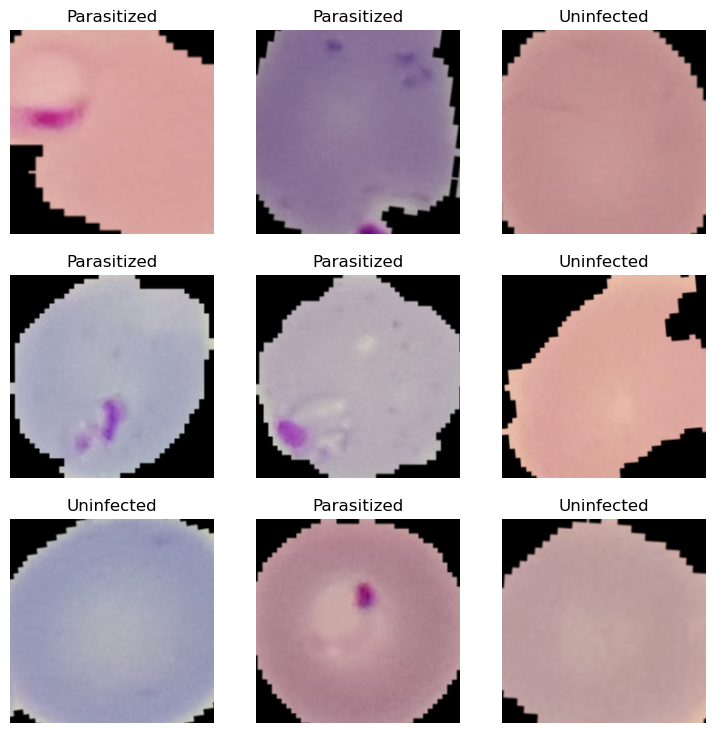

In [41]:
# Load dataset into fastai

path = Path(DATASET_DIR)

splitter = RandomSplitter(valid_pct=0.2)

item_tfms = [Resize(224)]
batch_tfms = [
    *aug_transforms(flip_vert=True, max_zoom=1.2, max_warp=0),
    Normalize.from_stats(*imagenet_stats),
]

data_block = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    get_items=get_image_files,
    get_y=parent_label,
    splitter=splitter,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

data = data_block.dataloaders(path, bs=64)
data.show_batch()

In [18]:
# Load a pre-trained model
# https://docs.fast.ai/vision.models.xresnet.html
learner = cnn_learner(data, xresnet34, metrics=[accuracy]).to_fp16()

In [19]:
# Fine-tune model on our dataset
learner.fine_tune(15)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Msagardi\AppData\Local\anaconda3\envs\label\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Msagardi\AppData\Local\Temp\ipykernel_38904\417006914.py", line 2, in <module>
    learner.fine_tune(15)
  File "c:\Users\Msagardi\AppData\Local\anaconda3\envs\label\lib\site-packages\fastai\callback\schedule.py", line 168, in fine_tune
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
  File "c:\Users\Msagardi\AppData\Local\anaconda3\envs\label\lib\site-packages\fastai\callback\schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "c:\Users\Msagardi\AppData\Local\anaconda3\envs\label\lib\site-packages\fastai\learner.py", line 264, in fit
    self._with_events(self._do_fit, 'fit', CancelFitEx

In [21]:
# This will print the validation loss and metrics
# Return loss & accuracy of validation set/split
learner.validate()

(#2) [0.10959086567163467,0.9602612853050232]

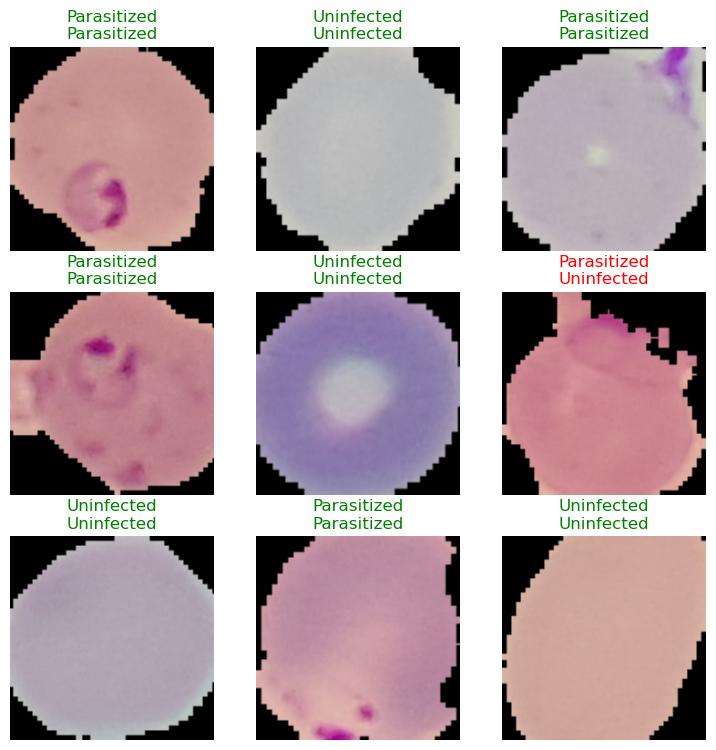

In [20]:
# Preview some predictions
learner.show_results()

In [22]:
# Save model checkpoint
# A folder ./models is created and the model with name xresnet34-malaria.pth
# saved in it
learner.save("xresnet34-malaria")

Path('models/xresnet34-malaria.pth')

In [42]:
# Loads `./models/xresnet34-malaria.pth` generated by `.save()`
learner = cnn_learner(data, xresnet34, metrics=[accuracy]).to_fp16()
learner.load("xresnet34-malaria")

c:\Users\Msagardi\AppData\Local\anaconda3\envs\label\lib\site-packages\fastai\vision\learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


## 4. Evaluate the Model with Fast.ai

### Add Predictions to FiftyOne

We can predict the targets with our model and add them to the FiftyOne dataset as follows.
Then, we can compute some evaluation aggregate metrics easily.

In [9]:
import os
from pathlib import Path
from fiftyone import ViewField as F

def normalize_path(filepath):
    # This function is probably not always necessary
    # but when the paths in FiftyOne and in our dataloader don't match
    path = Path(filepath).resolve()
    return str(path).replace(str(path.drive), str(path.drive).lower()) # C:\\ -> c:\\

def do_inference(learner, dl, dataset, classes, tag):
    # Perform inference
    preds, _ = learner.get_preds(ds_idx=dl.split_idx)
    preds = preds.numpy()
    #preds = np.array([0, 0, 0])

    sample_count = 0
    tagged_count = 0

    # Save predictions to FiftyOne dataset
    with fo.ProgressBar() as pb:
        for filepath, scores in zip(pb(dl.items), preds):
            try:
                # Normalize the file path
                normalized_path = normalize_path(filepath)
                
                sample = dataset[normalized_path]
                target = np.argmax(scores)
                sample.tags.append(tag)  # Ensure tags are added, not replaced
                sample["predictions"] = fo.Classification(
                    label=classes[target],
                    confidence=scores[target],
                    logits=np.log(scores + 1e-9),  # add epsilon to avoid log(0)
                )
                sample.save()
                tagged_count += 1
            except KeyError as err:
                print(f"Filepath not found in dataset: {filepath}")
            sample_count += 1

    print(f"Processed {sample_count} samples.")
    print(f"Tagged {tagged_count} samples.")

    if tagged_count == 0:
        raise ValueError(f"No samples were tagged with '{tag}'. Please check the dataset and file paths.")


In [74]:
# Run inference on validation split
do_inference(learner, data.valid, dataset, classes, "validation")

c:\Users\Msagardi\AppData\Local\anaconda3\envs\label\lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
c:\Users\Msagardi\AppData\Local\anaconda3\envs\label\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
c:\Users\Msagardi\AppData\Local\anaconda3\envs\label\lib\site-packages\torch\cuda\amp\grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


 100% |███████████████| 5511/5511 [22.6s elapsed, 0s remaining, 248.3 samples/s]      
Processed 5511 samples.
Tagged 5511 samples.


In [75]:
# Run inference on train split
do_inference(learner, data.train, dataset, classes, "train")

 100% |█████████████| 22047/22047 [1.4m elapsed, 0s remaining, 309.3 samples/s]      
Processed 22047 samples.
Tagged 22047 samples.


In [76]:
# Check that the field prediction exists
print(dataset)

Name:        malaria-cell-images
Media type:  image
Num samples: 27558
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    uniqueness:   fiftyone.core.fields.FloatField
    predictions:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


In [77]:
# Prediction in the first sample of the train split
print(dataset.match_tags("train").first())

<SampleView: {
    'id': '6543c920416f0d1ba1770748',
    'media_type': 'image',
    'filepath': 'c:\\Users\\Msagardi\\git_repositories\\tool_guides\\fiftyone\\datasets\\cell_images\\Parasitized\\C100P61ThinF_IMG_20150918_144104_cell_164.png',
    'tags': ['train'],
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '6543c920416f0d1ba1770746',
        'tags': [],
        'label': 'Parasitized',
        'confidence': None,
        'logits': None,
    }>,
    'uniqueness': 0.5713208660163872,
    'predictions': <Classification: {
        'id': '6544eb09416f0d1ba178aded',
        'tags': [],
        'label': 'Parasitized',
        'confidence': 0.9992115497589111,
        'logits': array([-7.8876124e-04, -7.1455283e+00], dtype=float32),
    }>,
}>


In [78]:
# Prediction in the first sample of the validation split
print(dataset.match_tags("validation").first())

<SampleView: {
    'id': '6543c920416f0d1ba1770743',
    'media_type': 'image',
    'filepath': 'c:\\Users\\Msagardi\\git_repositories\\tool_guides\\fiftyone\\datasets\\cell_images\\Parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png',
    'tags': ['validation', 'validation'],
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '6543c91f416f0d1ba1770742',
        'tags': [],
        'label': 'Parasitized',
        'confidence': None,
        'logits': None,
    }>,
    'uniqueness': 0.5962146371044951,
    'predictions': <Classification: {
        'id': '6544e4a5416f0d1ba17869d7',
        'tags': [],
        'label': 'Parasitized',
        'confidence': 0.9979081153869629,
        'logits': array([-2.0940758e-03, -6.1696906e+00], dtype=float32),
    }>,
}>


### Running the Evaluation with FiftyOne after Predictions Have Been Added

In [3]:
# Evaluating models with FiftyOne
# https://docs.voxel51.com/user_guide/evaluation.html
# Binary classification: https://docs.voxel51.com/user_guide/evaluation.html#binary-evaluation

# Evaluate the predictions in the `predictions` field with respect to the
# labels in the `ground_truth` field
results = dataset.evaluate_classifications(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
    method="binary",
    classes=["Uninfected", "Parasitized"],
)

In [4]:
# Aggregate metrics
results.print_report()

              precision    recall  f1-score   support

  Uninfected       0.94      0.98      0.96     13779
 Parasitized       0.98      0.94      0.96     13779

    accuracy                           0.96     27558
   macro avg       0.96      0.96      0.96     27558
weighted avg       0.96      0.96      0.96     27558



In [5]:
# Confusion matrix
plot = results.plot_confusion_matrix()
plot.show()

FigureWidget({
    'data': [{'mode': 'markers',
              'opacity': 0.1,
              'type': 'scatter',
              'uid': 'e600359e-ee81-4506-81dc-241219dc7c8a',
              'x': array([0, 1, 0, 1]),
              'y': array([0, 0, 1, 1])},
             {'colorscale': [[0.0, 'rgb(255,245,235)'], [0.125,
                             'rgb(254,230,206)'], [0.25, 'rgb(253,208,162)'],
                             [0.375, 'rgb(253,174,107)'], [0.5, 'rgb(253,141,60)'],
                             [0.625, 'rgb(241,105,19)'], [0.75, 'rgb(217,72,1)'],
                             [0.875, 'rgb(166,54,3)'], [1.0, 'rgb(127,39,4)']],
              'hoverinfo': 'skip',
              'showscale': False,
              'type': 'heatmap',
              'uid': '219d17be-8e8b-45b6-9930-8df2018d9b47',
              'z': array([[  857, 12922],
                          [13505,   274]], dtype=int64),
              'zmax': 13505,
              'zmin': 0},
             {'colorbar': {'len': 1, 'lenm


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



In [82]:
plot.freeze()  # replaces interactive plot with static image / KILLS KERNEL?

In [6]:
plot = results.plot_pr_curve()
plot.show()

FigureWidget({
    'data': [{'customdata': array([1.39474869e-05, 1.87158585e-05, 2.27689743e-05, ..., 9.99998808e-01,
                                   9.99999166e-01, 1.00000000e+00]),
              'fill': 'tozeroy',
              'hovertemplate': ('recall: %{x:.3f}<br>precision:' ... 'customdata:.3f}<extra></extra>'),
              'line': {'color': '#FF6D04'},
              'mode': 'lines',
              'type': 'scatter',
              'uid': '0db76c4f-9267-4a89-85ad-b27b48efd867',
              'x': array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ..., 1.45148414e-04,
                          7.25742071e-05, 0.00000000e+00]),
              'y': array([0.5       , 0.50001814, 0.50003629, ..., 1.        , 1.        ,
                          1.        ])}],
    'layout': {'margin': {'b': 0, 'l': 0, 'r': 0, 't': 30},
               'shapes': [{'line': {'dash': 'dash'}, 'type': 'line', 'x0': 0, 'x1': 1, 'y0': 1, 'y1': 0}],
               'template': '...',
               't


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds

Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



Could not connect session, trying again in 10 seconds

Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds

Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



Could not connect session, trying again in 10 seconds

Could not connect session, trying again in 10 se

In [ ]:
plot.freeze()  # replaces interactive plot with static image / KILLS KERNEL?

In [7]:
# Get counts of TP, TN, FP, FN
print(dataset.count_values("eval"))

{'TP': 12922, 'TN': 13505, 'FP': 274, 'FN': 857}


### Hardness and Mistakenness

In [17]:
# Compute hardness
# Identify samples that are more difficult for a model to learn
# so that training can be more focused around these hard samples.
# https://docs.voxel51.com/user_guide/brain.html#sample-hardness
import fiftyone.brain as fob

fob.compute_hardness(dataset, "predictions")

Computing hardness...


 100% |█████████████| 27558/27558 [1.1m elapsed, 0s remaining, 469.2 samples/s]      
Hardness computation complete


In [18]:
# Compute mistakenness
# Automatically identify the potential ground truth mistakes in your dataset
# https://docs.voxel51.com/user_guide/brain.html#label-mistakes
import fiftyone.brain as fob

fob.compute_mistakenness(dataset, "predictions", label_field="ground_truth")

Computing mistakenness...
Mistakenness computation complete


### Launch the App/UI and Visualize Metrics or Selected Samples

The previous evaluation with FiftyOne refers to aggregate metrics.
It is also possible to evaluate samples individually by generating views, i.e., by filtering samples in the UI.

We can launch the FiftyOne UI app in several ways; the two most common ways:

1. With code in our environment:

    ```python
    session = fo.launch_app(dataset, desktop=True) # Browser: http://localhost:5151
    session = fo.launch_app(dataset, desktop=False) # Embedded in Jupyter
    ```

2. In the CLI:

    ```bash
    # fiftyone app launch <dataset_name>
    (label) fiftyone app launch "malaria-cell-images"
    # Browser: http://localhost:5151
    ```

Launching the UI in the code has the advantage of obtaining the `session` object, with which can do additional things. However, if we use this approach:

- We should use Jupyter Lab notebooks, not VSCode; otherwise, we might have issues.
- We can click on "Create new View for Cell Output" and put the view side-by-side with our notebook code.

Basic usage of the UI:

- Left frame: select tags / labels / primitives (features added in code)
- Main frame: we can visualize several **panels**
  - Samples: we can click on each of them and a detailed view is opened
  - Histograms: we can select which vaiables to plot: labels, scalar values, etc.
  - Embeddings: we can plot scatterplots that represent the dataset
- We can add stages or filters, e.g.:
  - `Limit(int)` takes the number of samples we specify
  - `SortBy`
  - ...

After running the evaluation of the model, we have created many additional values for the samples (see left frame):

- `LABELS`: `ground_truth`, `predictions`
- `PRIMITIVES`:
  - `uniqueness`
  - `eval`: TP, TN, FP, FN
  - `hardness`: a float that refers to how dificult are the samples to be learnt by the model
  - `mistakenness`: a scalar that refers to the potential ground truth mistakes in your dataset

Now, we can visualize filtered samples using those values. To that end:

- We can select tags/values in the left frame
- We can apply filters in the main frame, e.g.: `SortBy`, `Limit`, etc.

It is also possible to access the filters via the SDK if we have the `session = fo.launch_app()` object.

Examples:

```python
# Show most unique CORRECT predictions on validation split
session.view = (
    dataset
    .match_tags("validation")
    .match(F("predictions.label") == F("ground_truth.label"))
    .sort_by("uniqueness", reverse=True)
)

# Show most unique INCORRECT predictions on validation split
session.view = (
    dataset
    .match_tags("validation")
    .match(F("predictions.label") != F("ground_truth.label"))
    .sort_by("uniqueness", reverse=True)
)

# Show the HARDEST FALSE POSITIVES on validation split
session.view = (
    dataset
    .match_tags("validation")
    .match(F("eval") == "FP")
    .sort_by("hardness", reverse=True)
)

# Show the HARDEST FALSE NEGATIVES on validation split
session.view = (
    dataset
    .match_tags("validation")
    .match(F("eval") == "FN")
    .sort_by("hardness", reverse=True)
)

# Show the most likely ANNOTATION MISTAKES on the train split
session.view = (
    dataset
    .match_tags("train")
    .sort_by("mistakenness", reverse=True)
)
```


![Malaria Dataset: Evaluation](../assets/malaria_ui_selection.png)

## 5. Export: Dataset, Selected Samples

### Export incorrect samples for further analysis

In [22]:
# Print stats about errors
train_fp = dataset.match_tags("train").match(F("eval") == "FP")
train_fn = dataset.match_tags("train").match(F("eval") == "FN")
valid_fp = dataset.match_tags("validation").match(F("eval") == "FP")
valid_fn = dataset.match_tags("validation").match(F("eval") == "FN")

print("Train FP: %d" % train_fp.count())
print("Train FN: %d" % train_fn.count())
print("Validation FP: %d" % valid_fp.count())
print("Validation FN: %d" % valid_fn.count())

Train FP: 228
Train FN: 696
Validation FP: 46
Validation FN: 161


In [24]:
# Export FP and FN samples to JSON
ERRORS_JSON_PATH = "xresnet34-malaria-errors.json"

errors = (
    dataset
    .match(F("eval").is_in(["FP", "FN"]))
    .set_field("ground_truth.logits", None)
    .set_field("predictions.logits", None)
)

# ./xresnet34-malaria-errors.json generated
errors.write_json(ERRORS_JSON_PATH, rel_dir=DATASET_DIR)

### Export Dataset

In [25]:
# Export dataset in JSON format (no images)
JSON_PATH = "malaria-cell-dataset.json"

# ./malaria-cell-dataset.json generated
dataset.write_json(JSON_PATH, rel_dir=DATASET_DIR)